### --- STEP 1: LOADING PBMC 3k DATASET ---

In [1]:
import scanpy as sc
import os

# --- 1. DEFINE THE NETWORK ---
# This sets up the relative paths.
# ".." means "go up one level" from the notebooks folder to the root.
repo_root = "../" 

# We define where the data should live
data_dir = os.path.join(repo_root, "data", "raw")
figure_dir = os.path.join(repo_root, "figures")

# --- 2. CREATE FOLDERS AUTOMATICALLY ---
# This ensures the code works even if you delete the folders later
os.makedirs(data_dir, exist_ok=True)
os.makedirs(figure_dir, exist_ok=True)

# --- 3. CONFIGURE SCANPY ---
# Tell Scanpy: "When I ask for a dataset, put it in MY data folder, not a system cache."
sc.settings.datasetdir = data_dir 
# Tell Scanpy: "When I save a plot, put it in MY figures folder."
sc.settings.figdir = figure_dir

print(f"System Ready.\nData will be stored in: {os.path.abspath(data_dir)}")

System Ready.
Data will be stored in: e:\Data_Science_Bio\single-cell-pbmc-analysis\data\raw


### A bit of information on PBMC:

PBMC stands for Peripheral Blood Mononuclear Cell. In plain English: It is a blood sample with the Red Blood Cells removed.

Blood Plasma (Blood WITHOUT any cells) + PBMC (Blood WITHOUT Red Blood Cells) + RBCs = Blood

PBMC = Immune System of the body (Mixture of various cells that defend the body)

PBMC =  Lymphocytes (T-Cells + B-Cells + NK(Natural Killer)) + Monocytes

In [8]:
print("Downloading PBMC 3k dataset...")

# This command goes to the 10x Genomics server, downloads the file,
# and saves it into your 'data/raw' folder defined above.
adata = sc.datasets.pbmc3k()

# 'adata' stands for Annotated Data. It is the core object in Scanpy.
print("\nSuccess! Data Loaded.")
print(adata)


Success! Data Loaded.
AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'


### Description of PBMC 3k dataset

PBMC dataset consists of "cells" as the rows (observations) and "genes" as the columns (features/variables)

The values are integers showing "RNA counts"

Eg: If Matrix[Cell_1, CD3D] = 15, it means Cell #1 is expressing the gene CD3D quite a bit. (Since CD3D is a marker for T-Cells, Cell #1 is likely a T-Cell).

In [ ]:
# Description of cells (observations)
adata.obs.head()
# adata.obs.describe()

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
count,2700.000000,2700.000000,2700.000000,2700.000000
mean,846.994074,2366.900391,50.806667,2.215132
std,282.104964,1094.262085,30.891550,1.165438
min,212.000000,548.000000,0.000000,0.000000
25%,690.000000,1757.750000,31.000000,1.536238
50%,817.000000,2197.000000,44.000000,2.029639
75%,953.250000,2763.000000,62.000000,2.640218
max,3422.000000,15844.000000,347.000000,22.569027


In [ ]:
# Description of genes (features)
adata.var.head()
# adata.var.describe()

,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
count,32738.000000,32738.000000,32738.000000,32738.000000
mean,69.854114,0.072298,97.412811,195.205292
std,238.263898,0.852401,8.824589,2301.482666
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,98.703704,0.000000
50%,1.000000,0.000370,99.962963,1.000000
75%,35.000000,0.013704,100.000000,37.000000
max,2700.000000,59.883333,100.000000,161685.000000


In [ ]:
# Matrix of cells and genes together
adata.to_df().iloc[:5, :10] # picking 5 cells and 10 genes together

index,MIR1302-10,FAM138A,OR4F5,RP11-34P13.7,RP11-34P13.8,AL627309.1,RP11-34P13.14,RP11-34P13.9,AP006222.2,RP4-669L17.10
index,,,,,,,,,,
AAACATACAACCAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGAGCTAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGATCAGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGTGCTTCCG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGTGTATGCG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### --- STEP 2: QUALITY CONTROL (QC) ---

In [ ]:
# 1. Identify Mitochondrial Genes
# Mitochondrial genes in humans start with "MT-". We tag them here.
# Create a new variable "mt" along with the other columns (genes) for only mitochondrial cells
adata.var['mt'] = adata.var_names.str.startswith('MT-') 

In [10]:
# 2. Calculate QC Metrics
# This function automatically counts:
# - 'n_genes_by_counts': How many different genes does this cell have?
# - 'total_counts': How many total RNA molecules did we catch?
# - 'pct_counts_mt': What percentage of the RNA is mitochondrial?
sc.pp.calculate_qc_metrics(
    adata, 
    qc_vars=['mt'], 
    percent_top=None, 
    log1p=False, 
    inplace=True
)

Plotting QC metrics before filtering...


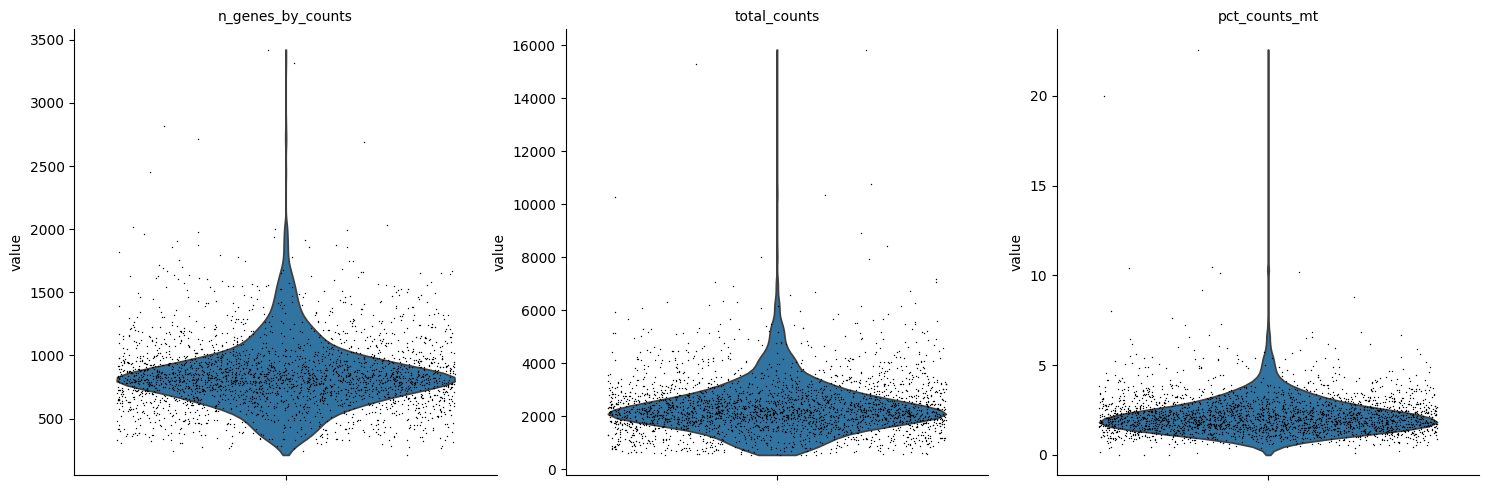

In [24]:
# 3. Visualize the "Mess" (Violin Plots)
# We plot these 3 metrics to see the distribution.
print("Plotting QC metrics before filtering...")
sc.pl.violin(
    adata, 
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4,             # Adds dots so you can see individual cells
    multi_panel=True
)

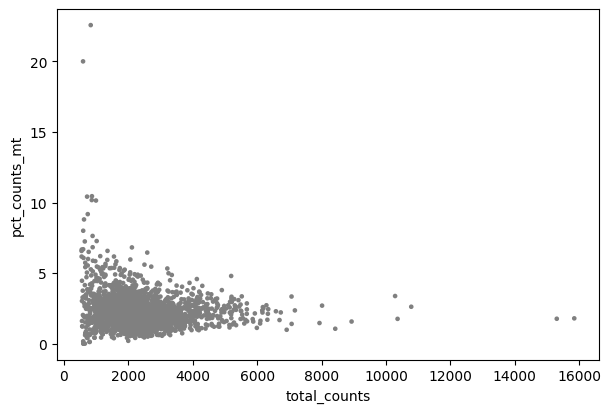

In [ ]:
# Scatter Plots (The "Correlation" Check)
# Dead cells usually have High MT% AND Low Total Counts.
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')

In [25]:
# 4. APPLY FILTERS ---
print(f"Original cell count: {adata.n_obs}")

# Keep cells with < 2500 genes (removes doublets)
# Keep cells with > 200 genes (removes empty droplets)
# Keep cells with < 5% MT genes (removes dead cells)
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy() 
# .copy() is crucial here to free up memory from the discarded cells

Original cell count: 2700


In [26]:
print(f"Filtered cell count: {adata.n_obs}")

Filtered cell count: 2638


In [27]:
# 5. SAVE THE CHECKPOINT ---
import os
# Ensure the processed data folder exists
processed_dir = os.path.join("..", "data", "processed")
os.makedirs(processed_dir, exist_ok=True)

# Save the clean matrix to the vault
checkpoint_path = os.path.join(processed_dir, "pbmc3k_qc_filtered.h5ad")
adata.write(checkpoint_path)

print(f"Success! Cleaned data saved to: {checkpoint_path}")

Success! Cleaned data saved to: ..\data\processed\pbmc3k_qc_filtered.h5ad
